<a href="https://colab.research.google.com/github/rishabh135/2015/blob/master/Resnet50_eigenvalues.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Look at distribution of eigenvalues and singular values of trained ResNet-50.

V2 fc layer eigenvalues appear to follow circular law, probably connected to the matrix being similar numeric rank to a random matrix of this size

# Eigenvalues

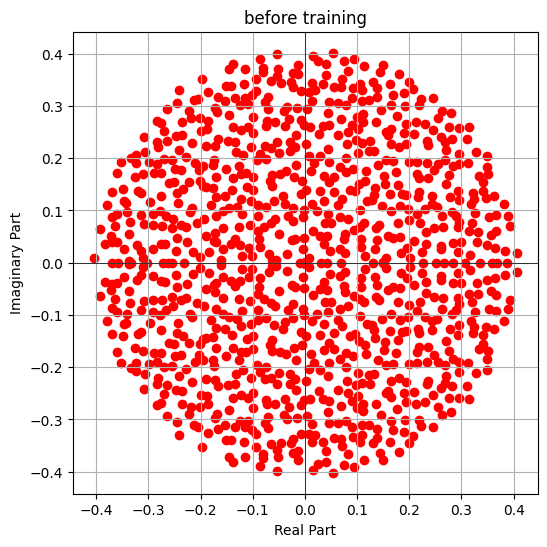

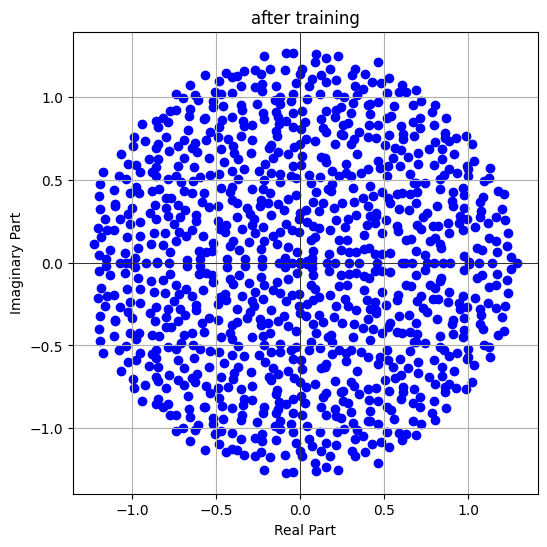

In [ ]:
import numpy as np
def visualize_eigs(array, label, color):
    pad_size = max(array.shape)
    pad_height = pad_size - array.shape[0]
    pad_width = pad_size - array.shape[1]
    square = np.pad(array, ((0, pad_height), (0, pad_width)))

    eigenvalues = np.linalg.eigvals(square)
    eigenvalues = np.sort_complex(eigenvalues)[1:]  # drop the largest eig

    # Extract real and imaginary parts
    real_parts = eigenvalues.real
    imag_parts = eigenvalues.imag

    # Plot
    plt.figure(figsize=(6, 6))
    plt.scatter(real_parts, imag_parts, color=color)
    plt.title(label)
    plt.xlabel('Real Part')
    plt.ylabel('Imaginary Part')
    plt.axhline(0, color='black',linewidth=0.5)
    plt.axvline(0, color='black',linewidth=0.5)
    plt.grid(True)
    plt.show()

from torchvision.models import resnet50, ResNet50_Weights
import numpy as np
import matplotlib.pyplot as plt


net=resnet50(weights=None)
visualize_eigs(net.fc.weight.cpu().detach().numpy(), "before training", "red")

net=resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
visualize_eigs(net.fc.weight.cpu().detach().numpy(), "after training", "blue")

# Singular values

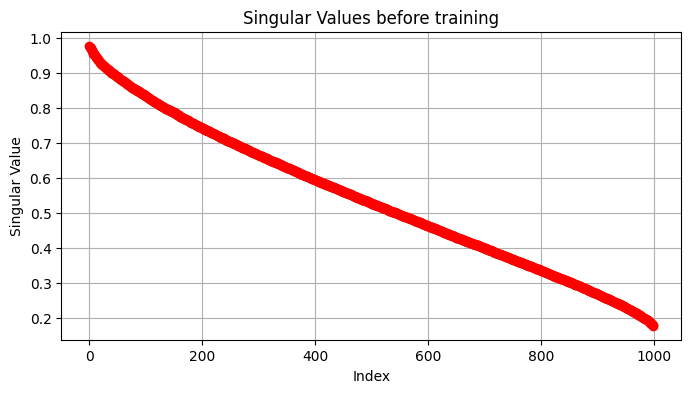

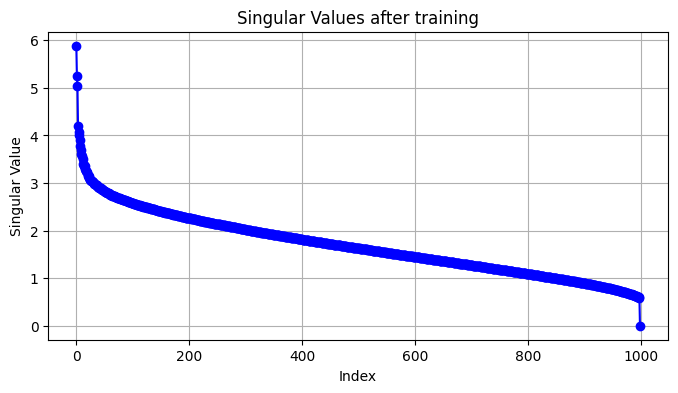

In [ ]:
weight0=resnet50(weights=None).fc.weight.cpu().detach().numpy()
weight1=resnet50(weights=ResNet50_Weights.IMAGENET1K_V2).fc.weight.cpu().detach().numpy()

# Plot singular values
U, singular_values, Vt = np.linalg.svd(weight0, full_matrices=False)

plt.figure(figsize=(8, 4))
plt.plot(singular_values, 'o-', color='red')
plt.title('Singular Values before training')
plt.xlabel('Index')
plt.ylabel('Singular Value')
plt.grid(True)
plt.show()

# Plot singular values
U, singular_values, Vt = np.linalg.svd(weight1, full_matrices=False)

plt.figure(figsize=(8, 4))
plt.plot(singular_values, 'o-', color='blue')
plt.title('Singular Values after training')
plt.xlabel('Index')
plt.ylabel('Singular Value')
plt.grid(True)
plt.show()

# Effective ranks of V1 vs V2

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights
import numpy as np
import matplotlib.pyplot as plt
import torch

def erank(X):
    """More efficient way of computing (svals**2).sum()**2/(svals**4).sum()
    aka, intrinsic dimension of X@X.T

    see https://scicomp.stackexchange.com/questions/43039/estimating-the-sum-of-4th-powers-of-singular-values
    and "How to count dimensions"
    """

    # (svals**2).sum() == np.linalg.norm(mat,"fro")**2
    # np.trace(mat@mat.T@mat@mat.T) == np.linalg.norm(mat@mat.T,"fro")**2
    return np.linalg.norm(X,"fro")**4 / np.linalg.norm(X@X.T,'fro')**2

def to_matrix(weight):
    return weight.reshape(weight.shape[0], -1)

def get_weight(net, target):
    for name, module in net.named_modules():
        if name == target:
            return module.weight.data.detach().cpu().numpy()

import torch


net0=resnet50(weights=None)
net1=resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
net2=resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

data = []
for layer in net.named_modules():
    if isinstance(layer[1], torch.nn.Linear) or isinstance(layer[1], torch.nn.Conv2d):
        weight0 = get_weight(net0, layer[0])
        weight1 = get_weight(net1, layer[0])
        weight2 = get_weight(net2, layer[0])
        matrix0 = to_matrix(weight0)
        matrix1 = to_matrix(weight1)
        matrix2 = to_matrix(weight2)

        max_rank = min(matrix0.shape)
        data.append([layer[0], max_rank, int(erank(matrix0)), int(erank(matrix1)), int(erank(matrix2))])
import pandas as pd
df = pd.DataFrame(data, columns=['Layer', 'algebraic rank', 'rank before training', 'rank trained V1', 'rank trained V2'])

df

,Layer,algebraic rank,rank before training,rank trained V1,rank trained V2
0,conv1,64,44,17,20
1,layer1.0.conv1,64,31,18,25
2,layer1.0.conv2,64,57,17,26
3,layer1.0.conv3,64,50,17,21
4,layer1.0.downsample.0,64,50,23,20
5,layer1.1.conv1,64,51,21,34
6,layer1.1.conv2,64,57,27,42
7,layer1.1.conv3,64,50,30,40
8,layer1.2.conv1,64,50,21,33
9,layer1.2.conv2,64,57,32,41


# Eigenvalue distributions for all layers

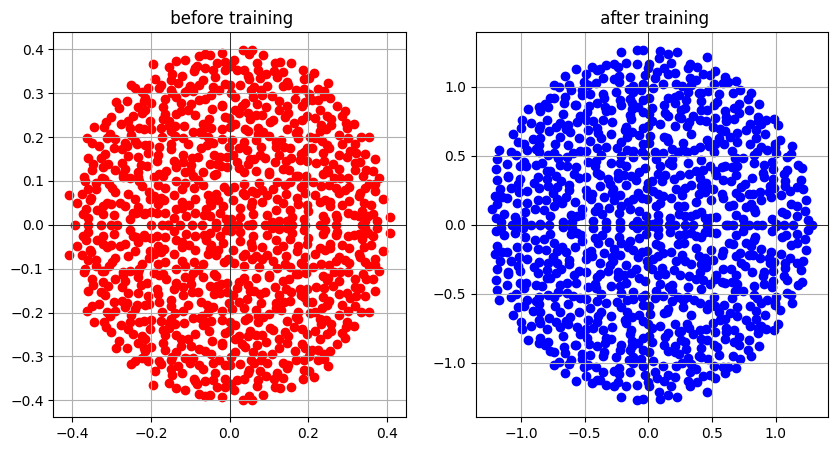

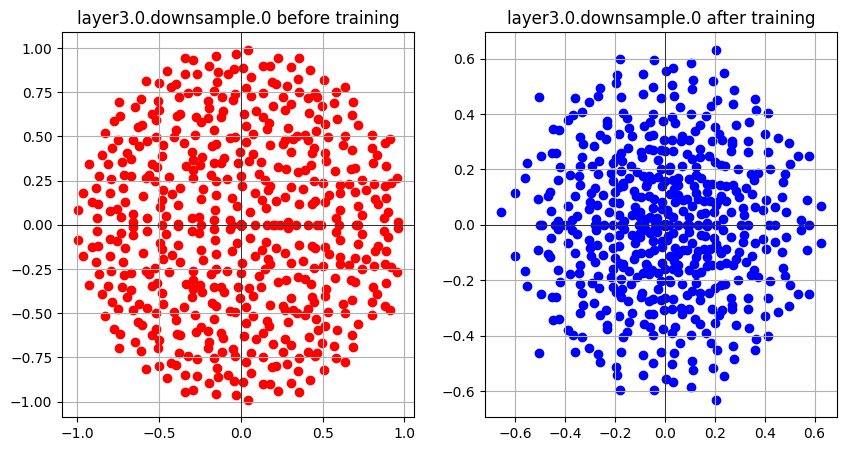

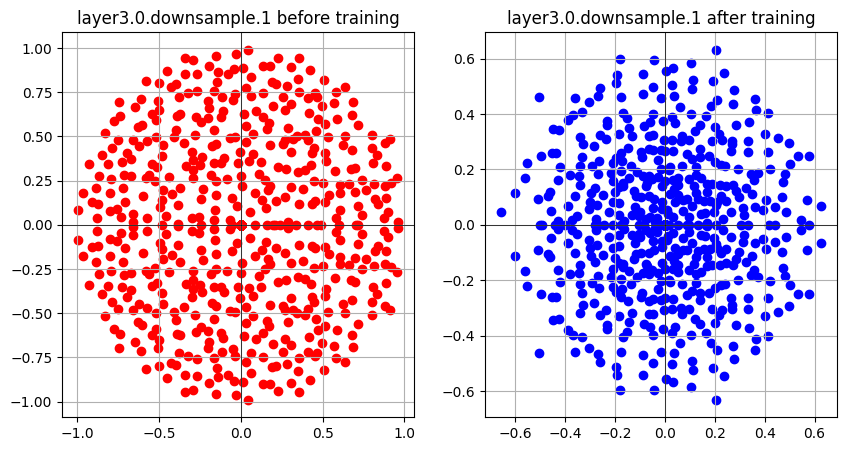

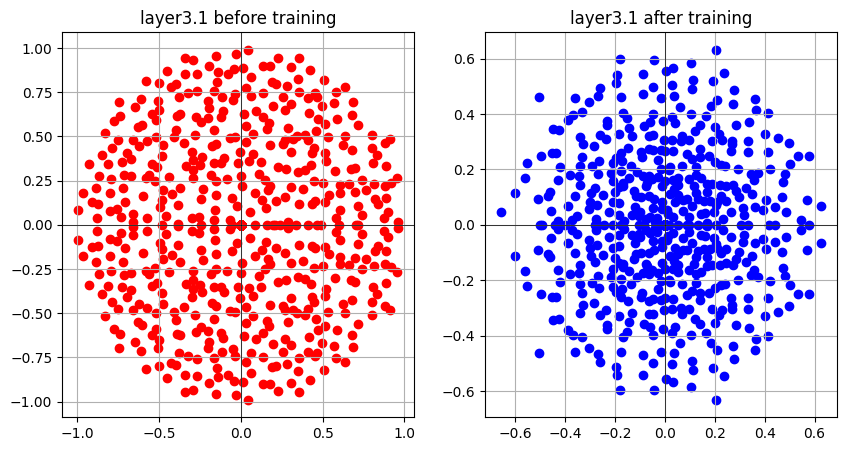

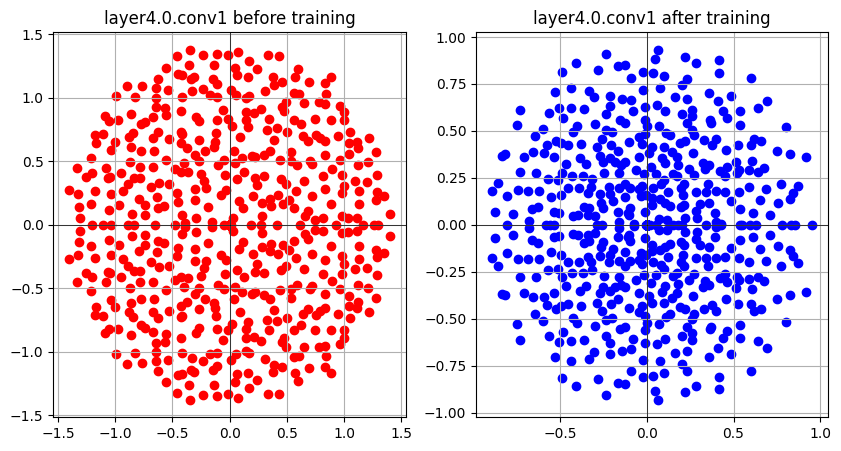

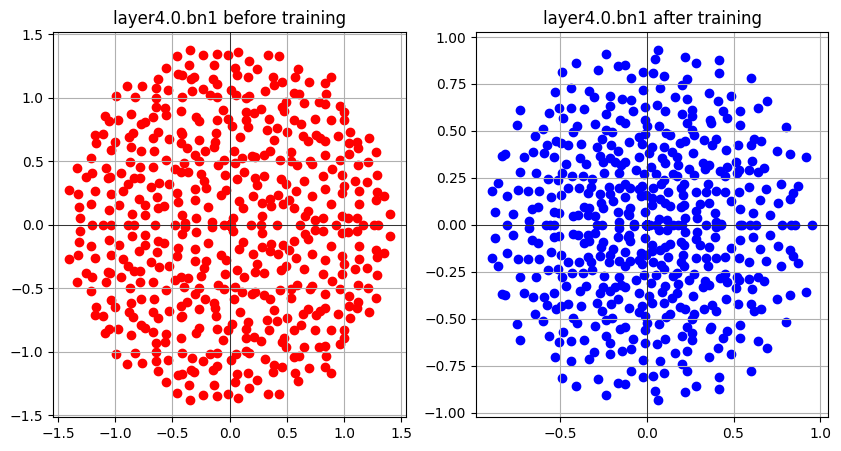

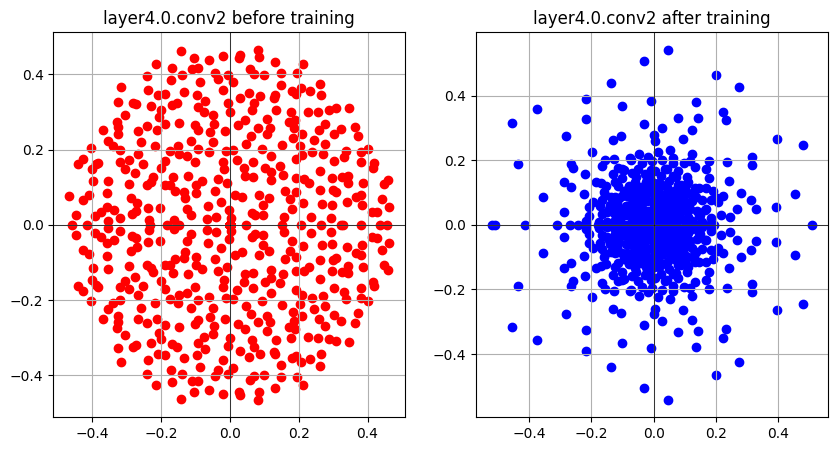

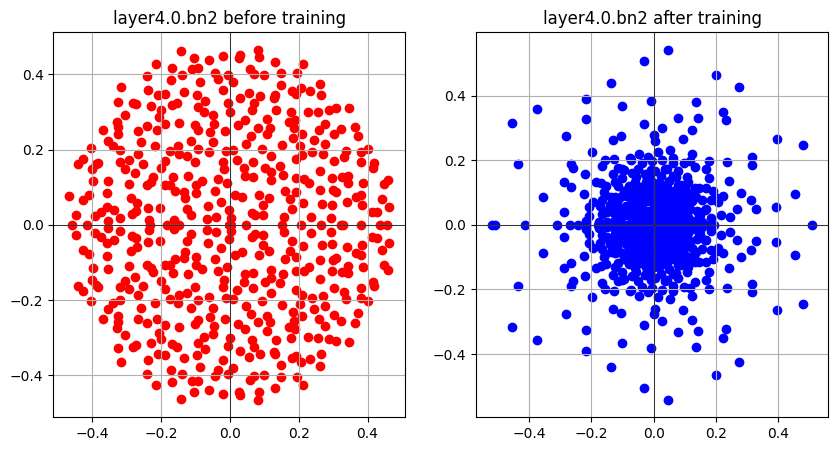

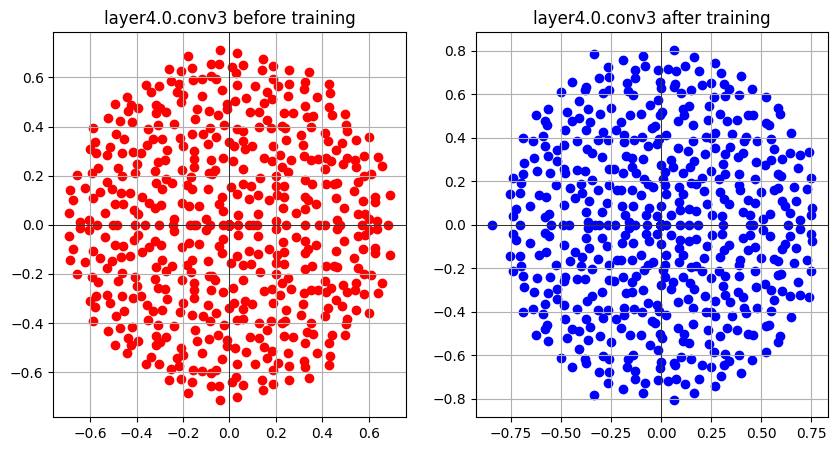

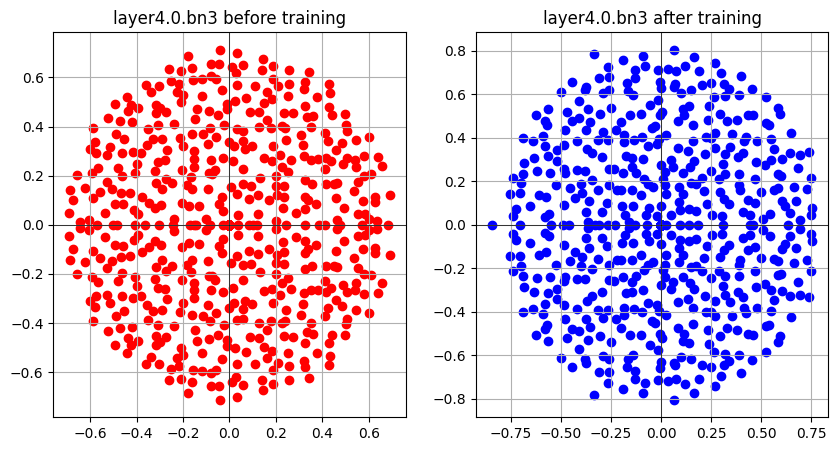

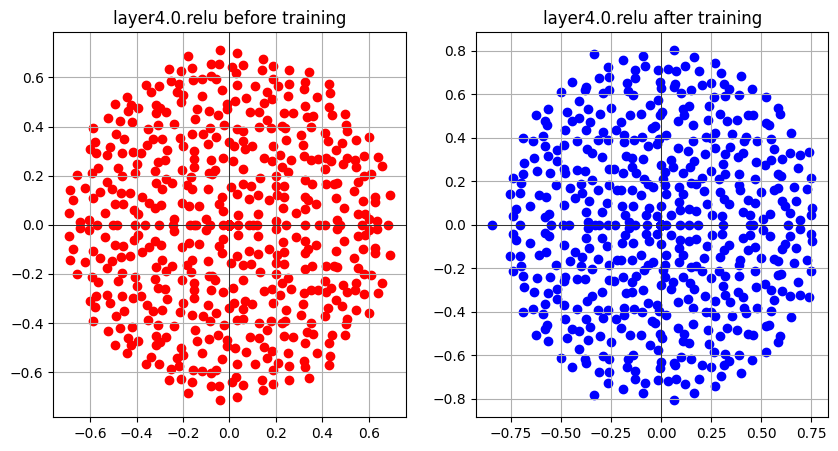

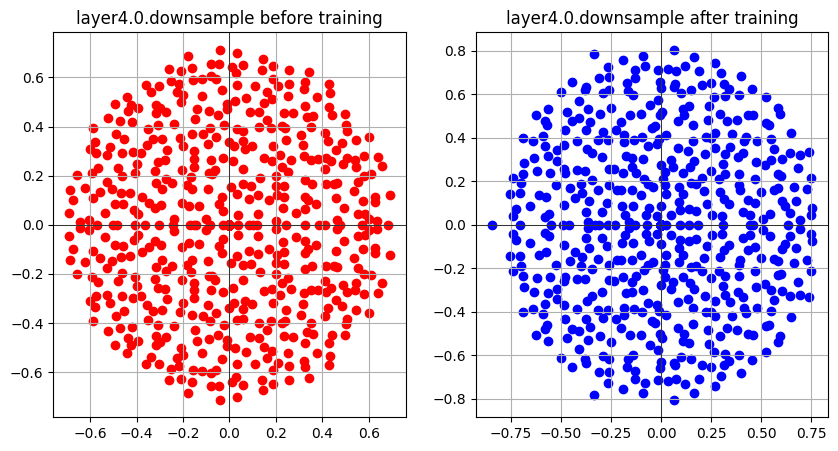

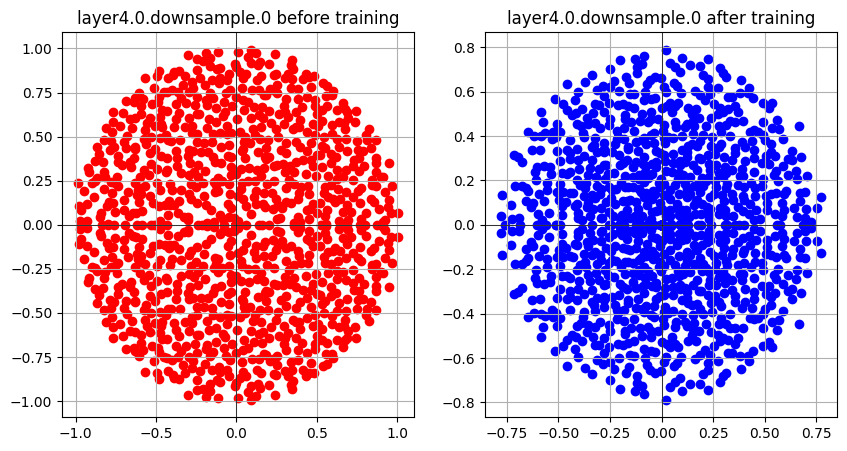

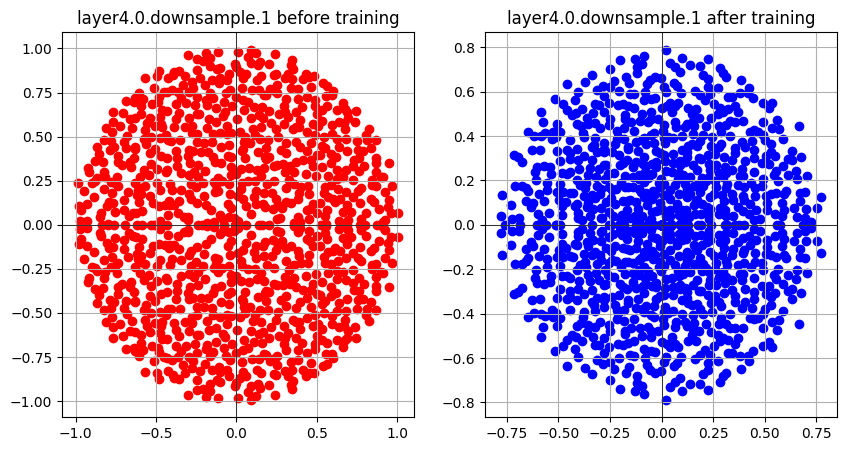

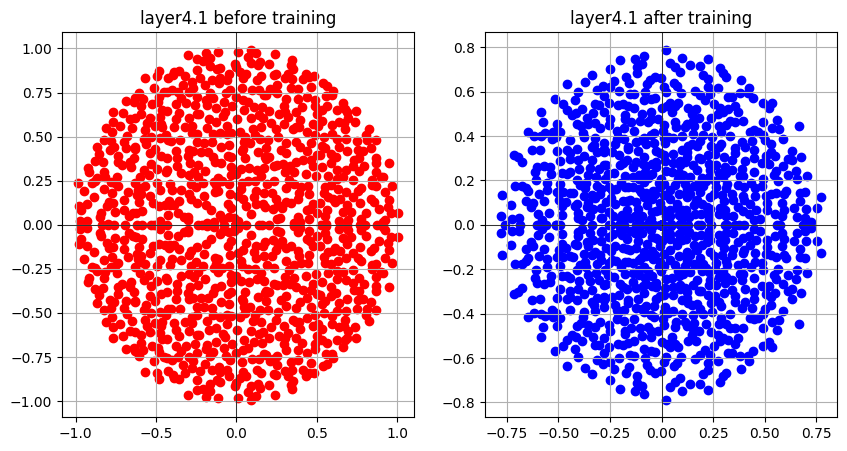

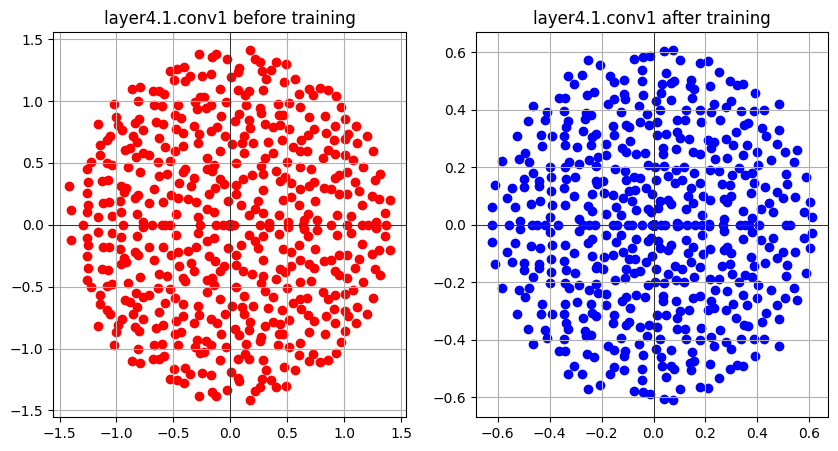

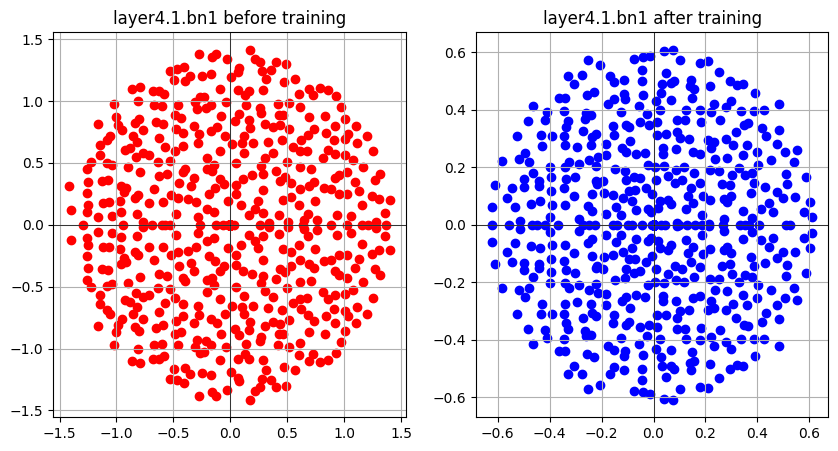

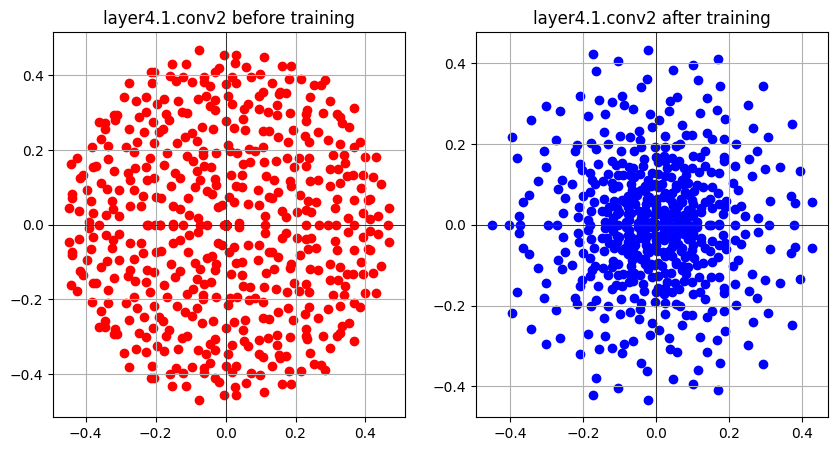

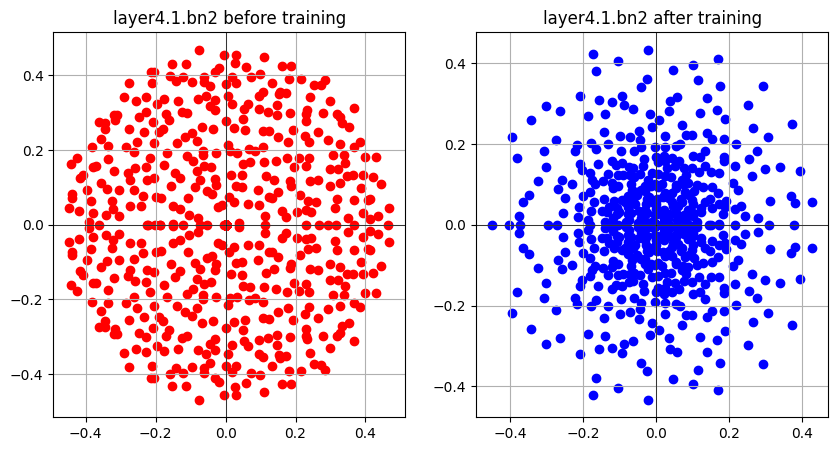

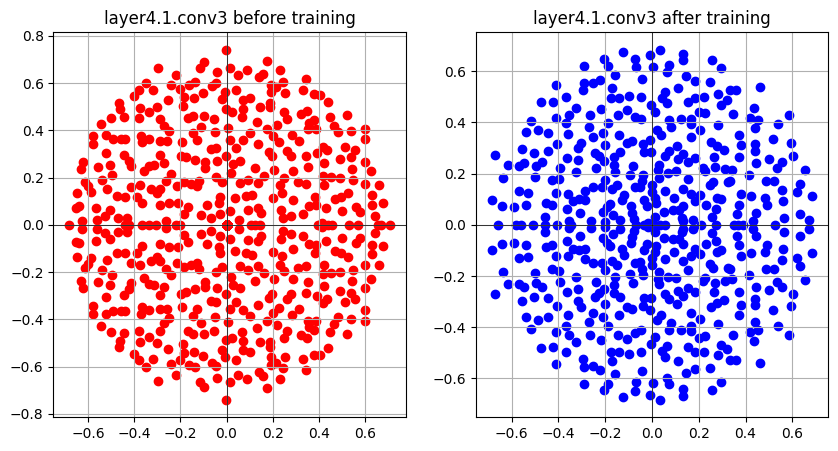

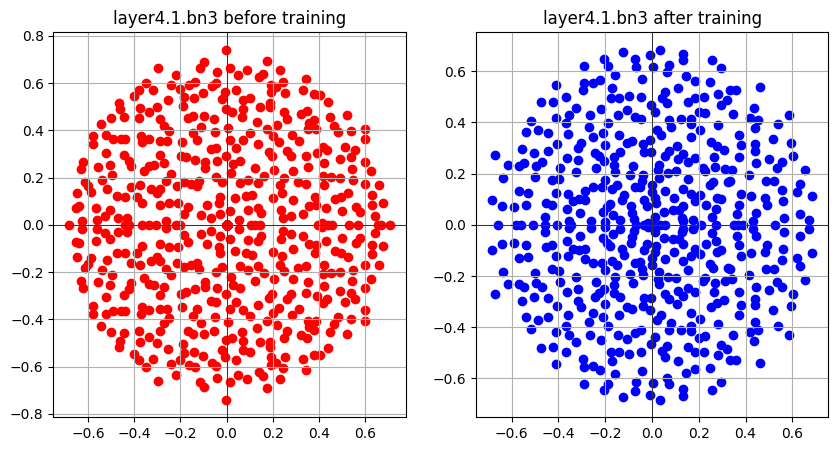

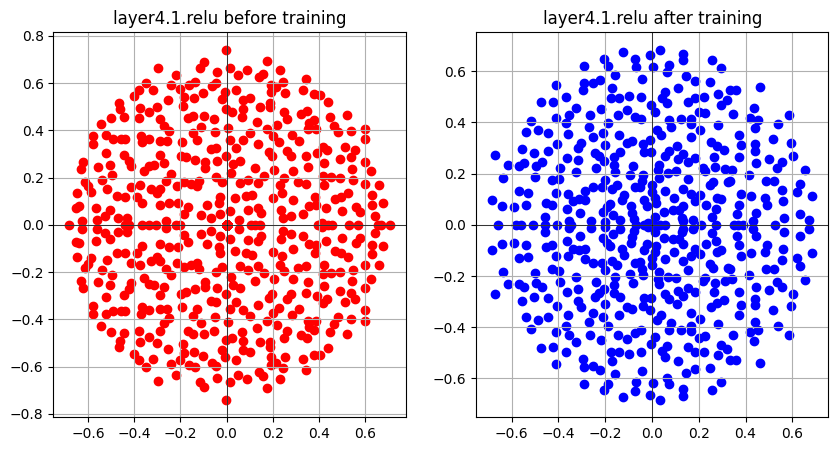

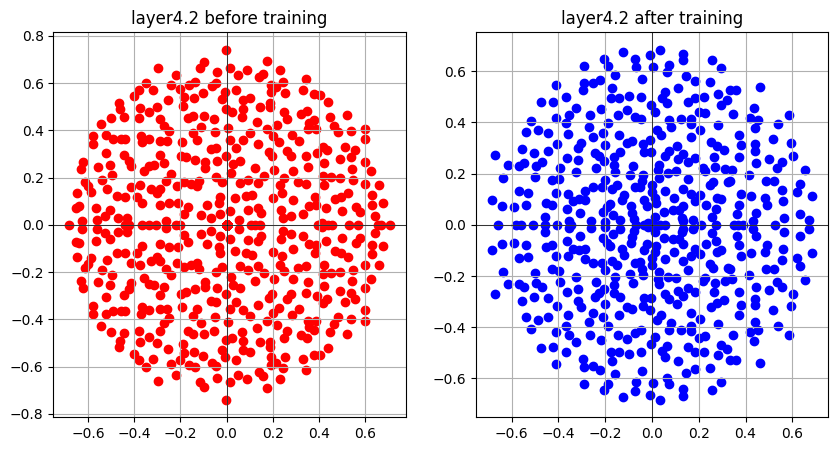

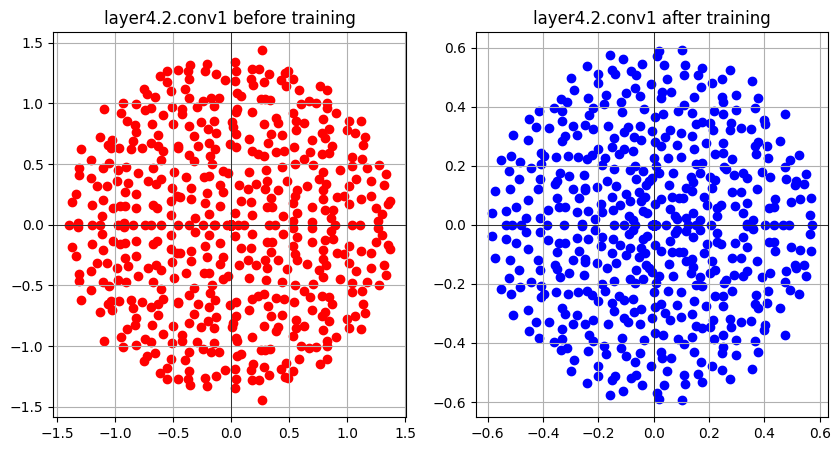

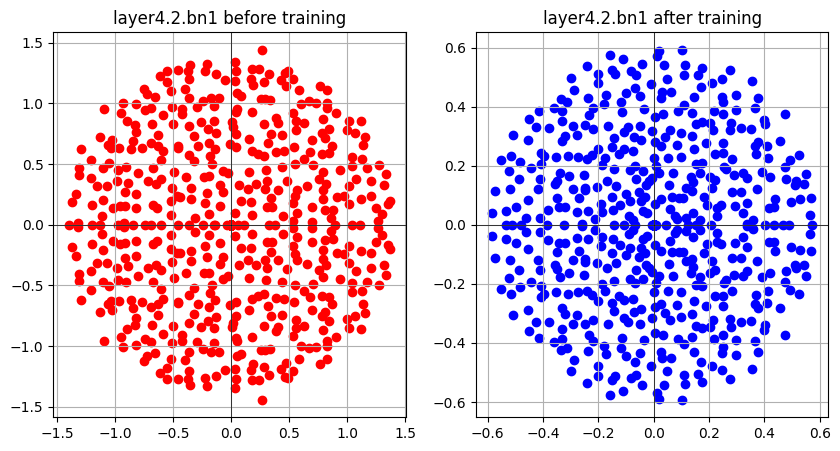

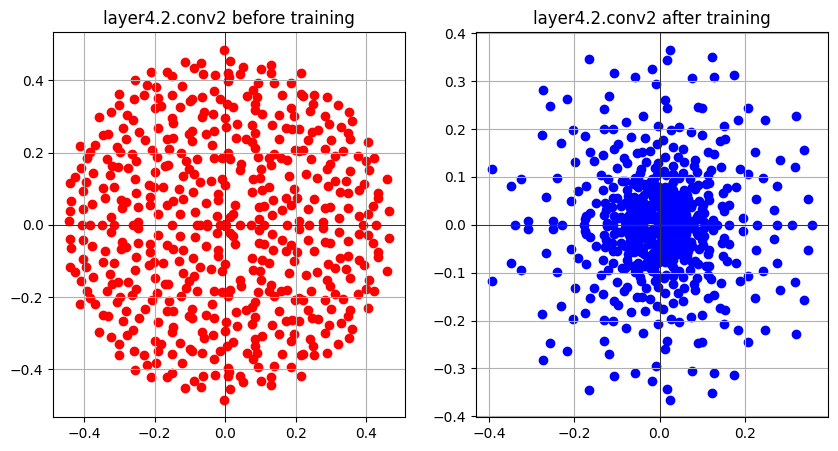

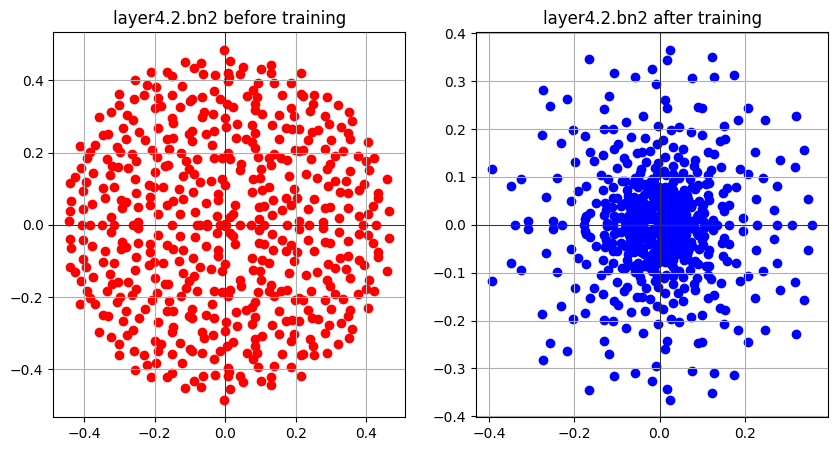

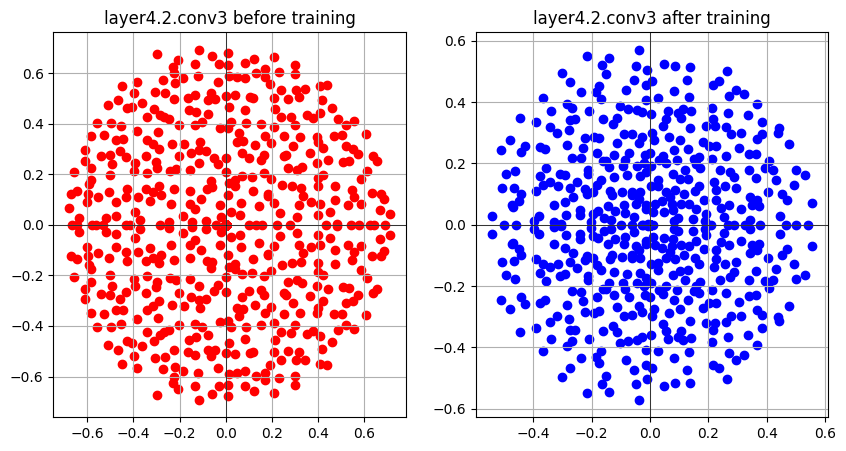

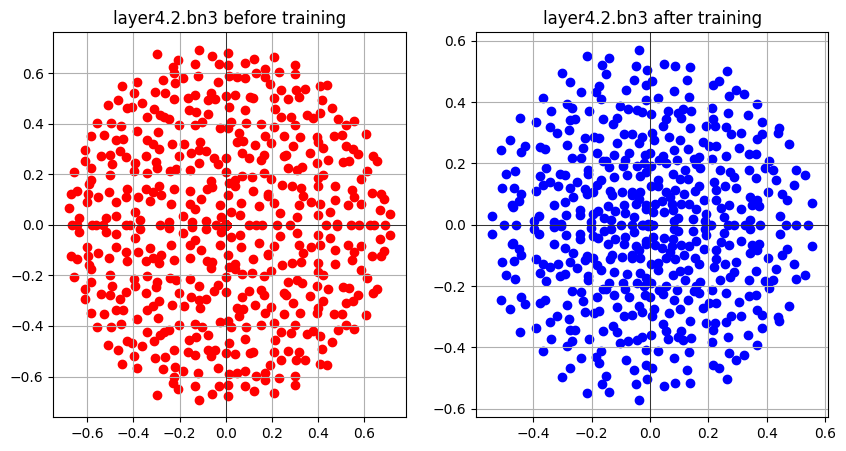

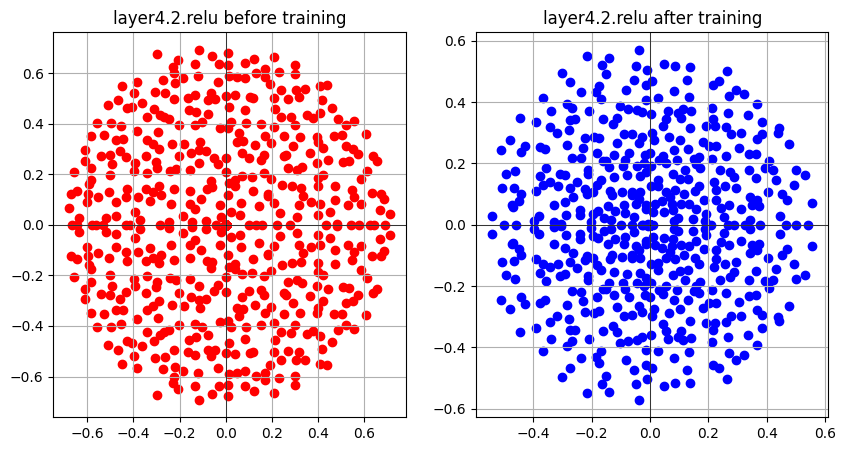

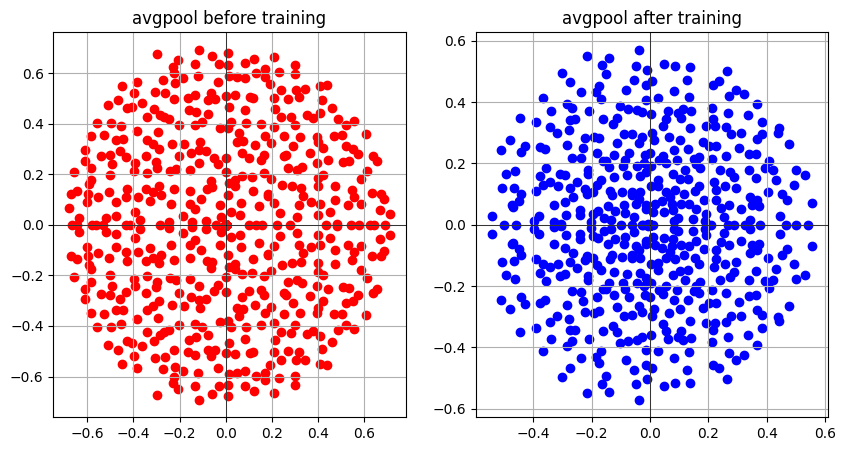

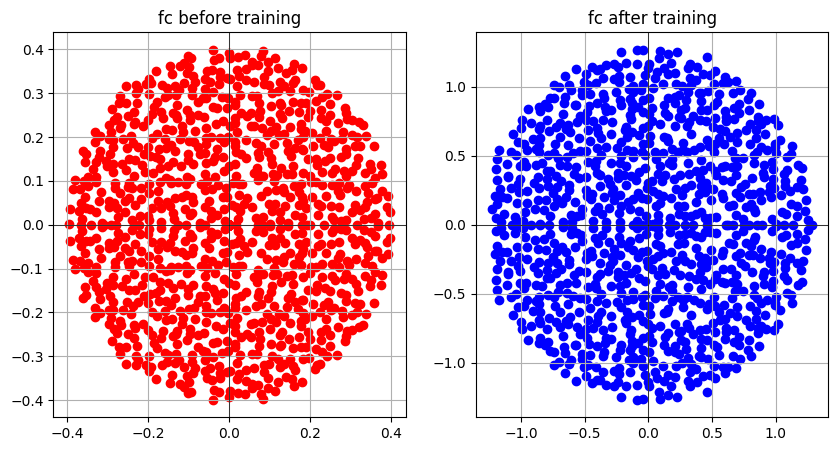

In [ ]:
def visualize_pair(array, array2, label):
    pad_size = max(array.shape)
    pad_height = pad_size - array.shape[0]
    pad_width = pad_size - array.shape[1]
    square = np.pad(array, ((0, pad_height), (0, pad_width)))

    eigenvalues = np.linalg.eigvals(square)
    eigenvalues = np.sort_complex(eigenvalues)[1:]  # drop the largest eig

    # Extract real and imaginary parts
    real_parts = eigenvalues.real
    imag_parts = eigenvalues.imag

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

def make_square(array):
    pad_size = max(array.shape)
    pad_height = pad_size - array.shape[0]
    pad_width = pad_size - array.shape[1]
    return np.pad(array, ((0, pad_height), (0, pad_width)))

    # Plot
def visualize_pair(array, array2, label):
    eigenvalues = np.linalg.eigvals(make_square(array))
    eigenvalues = np.sort_complex(eigenvalues)[1:]  # drop the largest eig
    real_parts = eigenvalues.real
    imag_parts = eigenvalues.imag

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Plot
    axs[0].scatter(real_parts, imag_parts, color="red")
    axs[0].set_title(label+' before training')
    axs[0].axhline(0, color='black',linewidth=0.5)
    axs[0].axvline(0, color='black',linewidth=0.5)
    axs[0].grid(True)

    eigenvalues = np.linalg.eigvals(make_square(array2))
    eigenvalues = np.sort_complex(eigenvalues)[1:]  # drop the largest eig
    real_parts = eigenvalues.real
    imag_parts = eigenvalues.imag

    axs[1].scatter(real_parts, imag_parts, color="blue")
    axs[1].set_title(label+' after training')
    axs[1].axhline(0, color='black',linewidth=0.5)
    axs[1].axvline(0, color='black',linewidth=0.5)
    axs[1].grid(True)

    plt.show()


net0=resnet50(weights=None)
net1=resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
net2=resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

data = []
for layer in net.named_modules():
    if isinstance(layer[1], torch.nn.Linear) or isinstance(layer[1], torch.nn.Conv2d):
        weight0 = get_weight(net0, layer[0])
        weight1 = get_weight(net2, layer[0])
        matrix0 = to_matrix(weight0)
        matrix1 = to_matrix(weight1)

    if min(matrix0.shape) > 500:
        visualize_pair(matrix0, matrix1, layer[0])
